In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np

import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
# plt.style.use('bmh')
import matplotlib.ticker as ticker
import seaborn as sns
import scienceplots
from itertools import accumulate
import matplotlib.ticker as mticker


import torch

In [2]:
def plot_res(
    save_folders,
    num_runs,
    tasks,
    legends,
    lr_list,
    file_name=None,
    K=None,
    init_points=None,
):
    def _ensure_list(x, N):
        if isinstance(x, (list, tuple)):
            assert len(x) == N, "Length of save_folders must equal number of tasks"
            return list(x)
        return [x] * N

    def stack_runs(root, task, key, lr):
        curves = []
        for r in num_runs:
            if task in {"diffusion_distr_est", "diffusion_point_est", "diffusion_distr_est_resample"}:
                fpath = os.path.join(root, f"{r}_{lr}", f"{task}")
            else:
                fpath = os.path.join(root, str(r), f"{task}")

            if not os.path.exists(fpath):
                # Try with a .pt extension if present
                alt = fpath + ".pt"
                if os.path.exists(alt):
                    fpath = alt
                else:
                    # Skip missing run silently so the rest can still plot
                    continue

            res = torch.load(fpath, weights_only=True)
            values = np.asarray(res[key], dtype=float)
            if key == "total_training_time_list" and "diffusion" in task:
                values = np.fromiter(accumulate(values), dtype=float)
            if K is not None:
                values = values[:K]
            if values.shape[0] == 50 or K is not None:
                curves.append(values)
        if len(curves) == 0:
            return None
        # Align by the shortest length (in case different runs have different epochs kept)
        min_len = min(len(c) for c in curves)
        curves = [c[:min_len] for c in curves]
        return np.stack(curves)

    # ----------------------------------------------------------------------
    N = len(tasks)
    save_folders = _ensure_list(save_folders, N)

    plt.style.use(["science", "no-latex"])  # requires scienceplots installed; remove if unneeded
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "axes.labelsize": 8,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "axes.linewidth": .6,
        "legend.fontsize": 7,
    })
    
    BLUE   = "#6FA8DC"
    ORANGE = "#F6B26B"
    base_colors = [BLUE, ORANGE, "#8FD19E", "#E57F7A", "#72B7B2", "#B279A2"]
    color_map = {legends[i]: base_colors[i % len(base_colors)] for i in range(len(legends))}

    metrics = [
        ("train_dfl_losses", "Train DFL loss"),
        ("val_dfl_losses",   "Val DFL loss"),
        ("test_dfl_losses",  "Test DFL loss"),
        ("total_training_time_list", "Cumulative training time (s)"),
    ]

    ls_pool = [
        "-", "--", "-.", ":",
        (0, (1, 1)), (0, (3, 1, 1, 1)), (0, (5, 1)),
        (0, (5, 2, 1, 2)), (0, (2, 2)), (0, (3, 5, 1, 5)),
    ]

    num_sub_fig = len(metrics)
    fig, axes = plt.subplots(1, num_sub_fig, figsize=(3.25 * num_sub_fig, 2.2), dpi=150, sharey=False)

    # Normalize axes to iterable
    if num_sub_fig == 1:
        axes = [axes]

    handles_all, labels_all = [], []

    for idx, (key, y_label) in enumerate(metrics):
        ax = axes[idx]
        for i, task in enumerate(tasks):
            root = save_folders[i]
            data = stack_runs(root, task, key, lr_list[i])  # (R, E)
            if data is None:
                continue

            if init_points is not None and key in init_points:
                init_val = float(init_points[key])
                init_col = np.full((data.shape[0], 1), init_val, dtype=float)  # (R, 1)
                data = np.concatenate([init_col, data], axis=1)  # (R, E+1)

            epochs = np.arange(data.shape[1])
            mean, std = data.mean(0), data.std(0)

            col = color_map[legends[i]]
            h, = ax.plot(
                epochs, mean,
                color=col,
                linestyle=ls_pool[i % len(ls_pool)],
                linewidth=1.2,
                label=legends[i]
            )
            ax.fill_between(epochs, mean - std, mean + std,
                            color=col, alpha=.18, linewidth=0)

            if idx == 0:
                handles_all.append(h)
                labels_all.append(legends[i])

        ax.set_xlabel("Epoch")
        ax.set_ylabel(y_label)
        ax.set_xlim(0, data.shape[1] - 1 if 'data' in locals() and data is not None else 50)
        ax.set_yscale("log", base=2)
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        ax.grid(True, axis="y", linewidth=.3, alpha=.6)
        plt.ticklabel_format(axis='y', style='plain')

    n_items = len(handles_all)
    if n_items:
        fig.legend(
            handles_all,
            labels_all,
            loc="lower center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=n_items,
            frameon=False,
            handlelength=2,
            columnspacing=1.0,
            fontsize=10,
        )

    agg_summary = []
    for i, task in enumerate(tasks):
        root = save_folders[i]
        data_ = stack_runs(root, task, key="test_dfl_losses", lr=lr_list[i])  # shape: (R, E)
        if data_ is None:
            print(f"- {legends[i]}: no runs found, skip.")
            continue

        per_run = data_.min(axis=1)              # (R,)
        epoch_per_run = data_.argmin(axis=1)     # (R,)

        sum   = float(per_run.sum())
        mean  = float(per_run.mean())
        std   = float(per_run.std())
        median = float(np.median(per_run))

        agg_summary.append({
            "task": task,
            "legend": legends[i],
            "n_runs": int(per_run.shape[0]),
            "sum": sum,
            "mean": mean,
            "std": std,
            "median": median,
            "min_ofs": float(per_run.min()),
            "max_ofs": float(per_run.max()),
        })

        print(f"- {legends[i]}: sum={sum:.6g} "
              f"(mean={mean:.6g}±{std:.3g}, "
              f"median={median:.6g}, n_runs={per_run.shape[0]})")

    fig.tight_layout(pad=.3, rect=[0, 0.06, 1, 1])

    if file_name is not None:
        plt.savefig(f"{file_name}.pdf", bbox_inches="tight", format="pdf", dpi=300)
    plt.show()

    return agg_summary

- sf_10: sum=9.61075 (mean=3.20358±0.0146, median=3.21391, n_runs=3)
- sf_50: sum=9.46554 (mean=3.15518±0.0939, median=3.17922, n_runs=3)
- sf_1000: sum=9.38228 (mean=3.12743±0.0845, median=3.15418, n_runs=3)
- reparam: sum=9.43886 (mean=3.14629±0.0703, median=3.16577, n_runs=3)


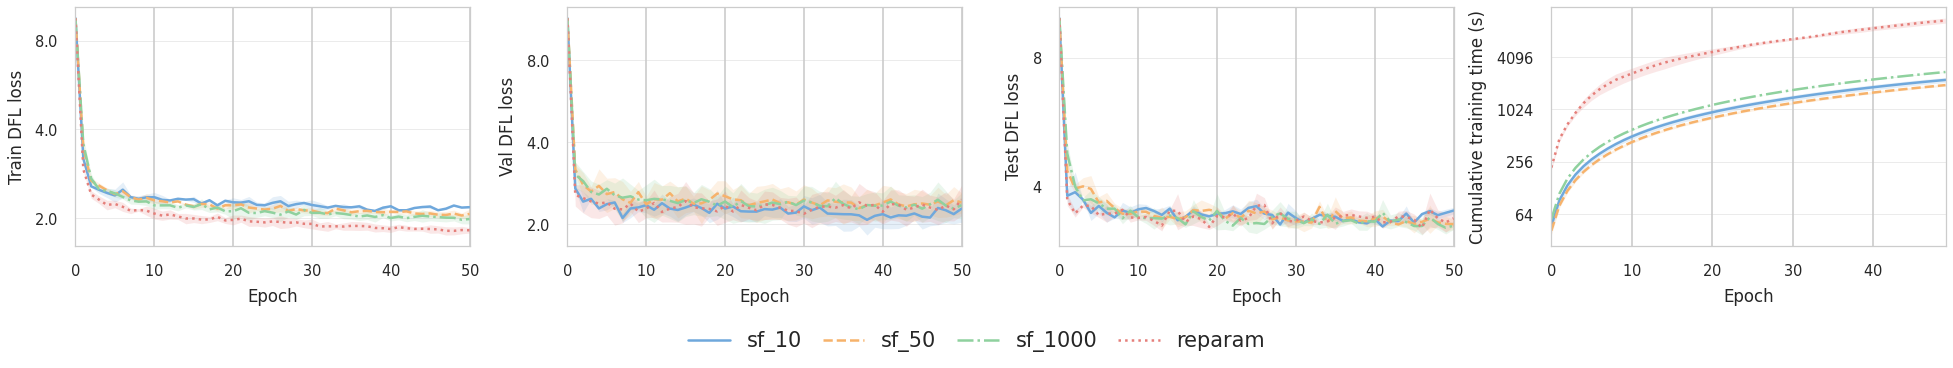

In [ ]:
YOUR_HOME_FOLDER = ""
YOUR_SAVE_FOLDER_NAME = ""
save_folders = [
        os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", YOUR_SAVE_FOLDER_NAME, "power_sched_results_tmp_compare_resample_10/"),
        os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", YOUR_SAVE_FOLDER_NAME, "power_sched_results_tmp_compare_resample_50/"),
        os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", YOUR_SAVE_FOLDER_NAME, "power_sched_results_tmp_compare_resample_1000/"),
        os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", YOUR_SAVE_FOLDER_NAME, "power_sched_results_tmp_compare_resample_800/"),
    ]

len_folders = len(save_folders)
tasks   = ["diffusion_distr_est"] * (len_folders - 1) + ["diffusion_point_est"]
legends = ["sf_10", "sf_50", "sf_1000", "reparam"]
lr_list = ["8e-06", "8e-06", "7e-06", "1e-05"]

runs = [2, 3, 4]

Init_train_DFL = 9.5345
Init_hold_DFL = 11.3900
Init_test_DFL = 9.8865
init_points = {
    "train_dfl_losses": Init_train_DFL,
    "val_dfl_losses":   Init_hold_DFL,
    "test_dfl_losses":  Init_test_DFL,
}

summary = plot_res(save_folders, runs, tasks, legends, lr_list, init_points=init_points, file_name="compare_sf_samples_size")

In [4]:
gpu_cost = {'10': 0.8319, '50':  3.4988, '1000': 66.9033, 'reparam': 60.7494}
test_dfl_loss = {'10': 3.2251, '50': 3.1551, '1000': 3.1710, 'reparam': 3.1525}

In [ ]:
def plot_two_panel(
    save_folders, num_runs, tasks, legends, lr_list,
    test_loss_dict, gpu_cost_dict, init_points=None,
    caption="", out_pdf="compare_gpu_and_time"
):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
    import seaborn as sns
    from itertools import accumulate

    def _ensure_list(x, N):
        if isinstance(x, (list, tuple)):
            assert len(x) == N
            return list(x)
        return [x] * N

    def stack_runs(root, task, key, lr):
        curves = []
        for r in num_runs:
            if task in {"diffusion_distr_est", "diffusion_point_est", "diffusion_distr_est_resample"}:
                fpath = os.path.join(root, f"{r}_{lr}", f"{task}")
            else:
                fpath = os.path.join(root, str(r), f"{task}")
            if not os.path.exists(fpath):
                alt = fpath + ".pt"
                if os.path.exists(alt):
                    fpath = alt
                else:
                    continue
            res = torch.load(fpath, weights_only=True)
            vals = np.asarray(res[key], dtype=float)
            curves.append(vals)
        if not curves:
            return None
        m = min(len(c) for c in curves)
        curves = [c[:m] for c in curves]
        return np.stack(curves)  # (R,E)

    N = len(tasks)
    save_folders = _ensure_list(save_folders, N)

    try: plt.style.use(["science", "no-latex"])
    except Exception: pass
    sns.set_theme(style="whitegrid", context="paper")
    plt.rcParams.update({
        "font.size": 8, "axes.labelsize": 9, "legend.fontsize": 8,
        "xtick.labelsize": 8, "ytick.labelsize": 8, "axes.linewidth": .6,
        "pdf.fonttype": 42, "ps.fonttype": 42
    })

    BLUE  = "#6FA8DC"
    ORANGE= "#F6B26B"
    # base_colors = [BLUE, ORANGE, "#8FD19E", "#E57F7A", "#72B7B2", "#B279A2"]
    base_colors = ["#4C78A8", "#F58518", "#54A24B", "#E45756", "#72B7B2", "#B279A2"]

    color_map = {legends[i]: base_colors[i % len(base_colors)] for i in range(len(legends))}

    ls_pool = ["-", "--", "-.", ":"]

    # fig, (ax_loss, ax_bars) = plt.subplots(1, 2, figsize=(6.2, 2.2), dpi=200)
    fig = plt.figure(figsize=(7.0, 1.8), dpi=220)
    gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 1.0], wspace=0.45)
    ax_loss = fig.add_subplot(gs[0, 0])
    ax_bars = fig.add_subplot(gs[0, 1])

    max_E = 0
    handles, labels = [], []
    for i, task in enumerate(tasks):
        data = stack_runs(save_folders[i], task, "test_dfl_losses", lr_list[i])
        if data is None: continue
        if init_points and "test_dfl_losses" in init_points:
            init = np.full((data.shape[0], 1), float(init_points["test_dfl_losses"]))
            data = np.concatenate([init, data], axis=1)
        epochs = np.arange(data.shape[1])
        mean, std = data.mean(0), data.std(0)
        max_E = max(max_E, data.shape[1])

        h, = ax_loss.plot(
            epochs, mean,
            color=color_map[legends[i]],
            linestyle=ls_pool[i % len(ls_pool)],
            linewidth=1.2, label=legends[i]
        )
        ax_loss.fill_between(epochs, mean - std, mean + std,
                             color=color_map[legends[i]], alpha=.18, linewidth=0)
        handles.append(h); labels.append(legends[i])

    if max_E > 0:
        ax_loss.set_xlim(0, max_E - 1)
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Test DFL loss")
    ax_loss.set_yscale("log", base=2)
    ax_loss.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax_loss.ticklabel_format(axis="y", style="plain")
    ax_loss.grid(True, axis="y", linewidth=.3, alpha=.6)
    sns.despine(ax=ax_loss, right=False, top=False)
    ax_loss.set_title("(a) Test loss for different methods", pad=20)

    LEG_Y = 1.2
    if handles:
        ax_loss.legend(handles, labels,
                    loc="upper center", bbox_to_anchor=(0.5, LEG_Y),
                    ncol=len(labels), frameon=False,
                    handlelength=2, columnspacing=1.0)

    def token_from_legend(lgd):
        return lgd.split(" ", 1)[1] if lgd.startswith("sf ") else lgd

    x = np.arange(len(legends))
    cost_vals = [float(gpu_cost_dict[token_from_legend(l)]) for l in legends]
    loss_vals = [float(test_loss_dict[token_from_legend(l)]) for l in legends]

    methods_order = ["ts"] + legends
    x = np.arange(len(methods_order))
    cost_vals = [float(gpu_cost_dict[token_from_legend(m)]) for m in methods_order]
    loss_vals = [float(test_loss_dict[token_from_legend(m)]) for m in methods_order]

    ax_left  = ax_bars
    ax_right = ax_left.twinx()

    bars = ax_left.bar(x, cost_vals, width=0.58, edgecolor="none",
                       color=BLUE, alpha=.95, label="GPU cost")
    (line,) = ax_right.plot(x, loss_vals, marker="o", linewidth=1.5,
                            color=ORANGE, label="Best test DFL loss")

    ax_left.set_xticks(x, methods_order)
    ax_left.set_xlabel("Method")
    ax_left.set_ylabel("GPU cost (GBs)")
    ax_right.set_ylabel("Test DFL loss")

    for b, c in zip(bars, cost_vals):
        ax_left.annotate(f"{c:.2f}", (b.get_x()+b.get_width()/2, b.get_height()),
                         ha="center", va="bottom", fontsize=7, xytext=(0,2),
                         textcoords="offset points")
    # for xi, yi in zip(x, loss_vals):
    #     ax_right.annotate(f"{yi:.2f}", (xi, yi), ha="center", va="bottom",
    #                       fontsize=7, xytext=(0,2), textcoords="offset points")

    ymin_vis, ymax_vis = ax_right.get_ylim()
    for xi, yi in zip(x, loss_vals):
        gap_ratio = (ymax_vis - yi) / (ymax_vis - ymin_vis)
        if gap_ratio < 0.10:
            va, dy = "top", -6
        else:
            va, dy = "bottom", 2
        ax_right.annotate(f"{yi:.2f}", (xi, yi),
                        ha="center", va=va, fontsize=7,
                        xytext=(0, dy), textcoords="offset points",
                        clip_on=True)

    # grids/spines
    ax_left.grid(True, axis="y", linewidth=.3, alpha=.6)
    sns.despine(ax=ax_left, right=False); sns.despine(ax=ax_right, left=True)

    # ax_bars.legend([bars, line], ["GPU cost", "Test DFL loss"],
    #                frameon=False, loc="upper left", fontsize=8)
    ax_bars.legend([bars, line], ["GPU cost", "Test DFL loss"],
               loc="upper center", bbox_to_anchor=(0.5, LEG_Y),
               ncol=2, frameon=False, handlelength=2, columnspacing=1.0, fontsize=8)

    ax_bars.set_title("Compare GPU cost & test loss", pad=20)

    for ax in (ax_left, ax_right):
        ax.minorticks_off()
        ax.yaxis.set_minor_locator(mticker.NullLocator())
        ax.tick_params(axis="y", which="minor", length=0)

    ax_left.grid(True, axis="y", which="major", linewidth=.3, alpha=.6)
    ax_left.grid(False, axis="y", which="minor")

    # ax_right.yaxis.set_major_locator(mticker.MaxNLocator(nbins=4, prune='both'))
    ax_right.set_yscale('log', base=2)
    ymax = max(loss_vals)
    ymin_pos = min(v for v in loss_vals if v > 0)
    ylo = 2 ** np.floor(np.log2(ymin_pos))
    yhi = 2 ** np.ceil(np.log2(ymax))
    ax_right.set_ylim(ylo, yhi)
    ax_right.yaxis.set_major_locator(mticker.LogLocator(base=2))
    ax_right.yaxis.set_minor_locator(mticker.NullLocator())
    ax_right.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{y:g}"))

    ymin_vis, ymax_vis = ax_right.get_ylim()
    for xi, yi in zip(x, loss_vals):
        gap_ratio = (ymax_vis - yi) / (ymax_vis - ymin_vis)
        if gap_ratio < 0.10:
            va, dy = "top", -6
        else:
            va, dy = "bottom", 2
        ax_right.annotate(f"{yi:.2f}", (xi, yi),
                        ha="center", va=va, fontsize=7,
                        xytext=(0, dy), textcoords="offset points",
                        clip_on=True)


    fig.tight_layout(pad=.6, rect=[0.03, 0.16, 1, 0.88])
    plt.savefig(f"{out_pdf}.pdf", bbox_inches="tight", dpi=300)

    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    to_inches = fig.dpi_scale_trans.inverted()
    bbox_a = ax_loss.get_tightbbox(renderer).transformed(to_inches).expanded(1.02, 1.08)
    bbox_b = ax_bars.get_tightbbox(renderer).transformed(to_inches).expanded(1.02, 1.08)

    fig.savefig(f"{out_pdf}_panel_a.pdf", bbox_inches=bbox_a, dpi=1000)
    fig.savefig(f"{out_pdf}_panel_b.pdf", bbox_inches=bbox_b, dpi=1000)

    plt.show()


/tmp/ipykernel_3237349/2395833568.py:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=.6, rect=[0.03, 0.16, 1, 0.88])


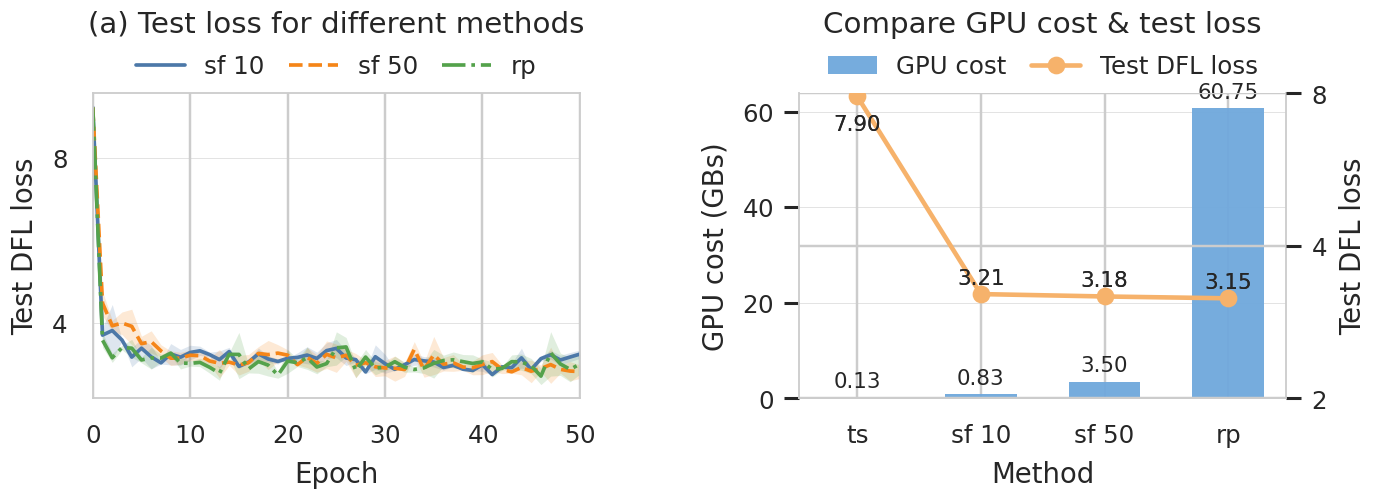

In [ ]:
YOUR_HOME_FOLDER = ""
save_folders = [
    os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", "power_sched_results_tmp_compare_resample_10/"),
    os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", "power_sched_results_tmp_compare_resample_50/"),
    os.path.join(YOUR_HOME_FOLDER, "e2e-model-learning", "power_sched", "power_sched_results_tmp_compare_resample_800/"),
]
tasks   = ["diffusion_distr_est", "diffusion_distr_est", "diffusion_point_est"]
legends = ["sf 10", "sf 50", "rp"]
lr_list = ["8e-06", "8e-06", "1e-05"]
runs = [2, 3, 4]

caption = ("Comparison of GPU cost and test loss.")

gpu_cost = {'ts': 0.13, '10': 0.8319, '50': 3.4988, 'rp': 60.7494}
test_dfl_loss = {'ts': 7.9015, '10': 3.21391, '50':3.17922, 'rp': 3.1525}


Init_train_DFL = 9.5345
Init_hold_DFL = 11.3900
Init_test_DFL = 9.8865
init_points = {
    "train_dfl_losses": Init_train_DFL,
    "val_dfl_losses":   Init_hold_DFL,
    "test_dfl_losses":  Init_test_DFL,
}

plot_two_panel(
    save_folders, runs, tasks, legends, lr_list,
    gpu_cost_dict=gpu_cost,
    test_loss_dict=test_dfl_loss,
    caption=caption,
    out_pdf="compare_gpu_and_time",
    
    init_points=init_points
)